In [1]:
#import relevant packages for analysis

from __future__ import print_function

import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

sns.set(rc = {'figure.figsize' : (11, 4)})

PROJ_ROOT = os.path.join(os.pardir)

In [2]:
%load_ext watermark
%watermark -a "Bryan Dickinson" -d -t -v -p numpy,pandas

Bryan Dickinson 2019-08-07 13:38:34 

CPython 3.7.3
IPython 7.7.0

numpy 1.16.4
pandas 0.25.0


In [3]:
#Create the path to the data and read into a pandas dataframe

terry_data = os.path.join(PROJ_ROOT, 
                         'data', 'processed',
                         'Terry_Stops_Clean.csv')

data = pd.read_csv(terry_data, parse_dates = ['date'], 
                   index_col = 'date', dtype = {'officer_race':'category','officer_gender':'category',
                                                'subject_age':'category',
                                                'subject_race':'category','subject_gender': 'category',
                                                'stop_resolution': 'category','weapon_type':'category',
                                                'call_type':'category','arrest':'int32', 'frisk':'float',
                                                'precinct':'category', 'sector':'category', 'beat': 'category'})

data.sort_index(inplace = True)

data['count'] = 1

### What is the overall trend of terry stops?

In [4]:
#copy the original dataframe and slice out the first and last full month from the data
df = data.copy()
df = df.loc['2015-04':'2019-04']

#Resample the dataframe for a monthly frequency and plot the number of stops
df = df['count'].resample('M').count()

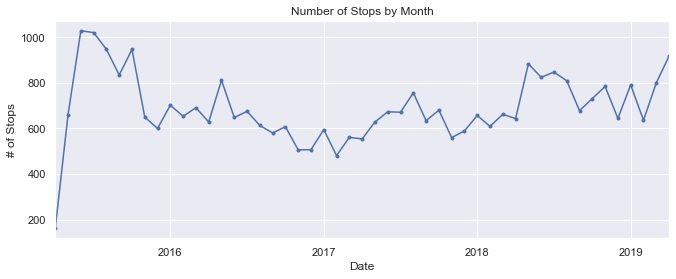

In [5]:
#plot the dataframe
df.plot( marker = '.', linestyle = None, figsize = (11,4))
_=plt.title('Number of Stops by Month')
_=plt.xlabel('Date')
_=plt.ylabel('# of Stops')


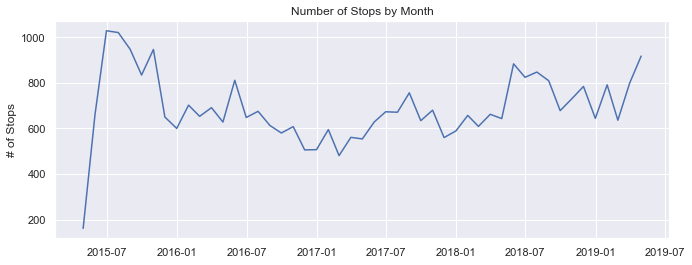

In [6]:


#plot the dataframe
plt.figure(figsize=(11, 4))
ax = sns.lineplot(data = df)
years = mdates.AutoDateLocator()
fmt = mdates.AutoDateFormatter(years)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(fmt)
_=plt.title('Number of Stops by Month')
_=plt.ylabel('# of Stops')
plt.show()

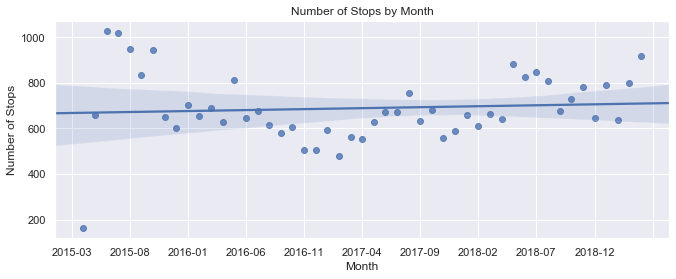

In [7]:
#import ticker to help with date visualization formatting
import matplotlib.ticker as ticker

# set x and y values for the seaborn plot
y = df.values
x = np.linspace(1, len(y), num = len(y))

plt.figure(figsize=(11, 4))
ax = plt.subplot(1,1,1)
p = sns.regplot(x , y)

#format x axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
dates = pd.date_range(start= '2014-10-31', end = df.index[-1], freq = '5M')
dates = [d.strftime('%Y-%m') for d in dates]
ax = ax.set_xticklabels(dates)


_= plt.title('Number of Stops by Month')
_= plt.xlabel('Month')
_= plt.ylabel('Number of Stops')


Overall the number of stops do not seem to be trending up or down over time. There was large increase in stops when tracking first started, followed by a large decrease in November of 2015. There was a large incrase in stops in May  - Aug of 2018.

### What is the racial comparisons of stops?

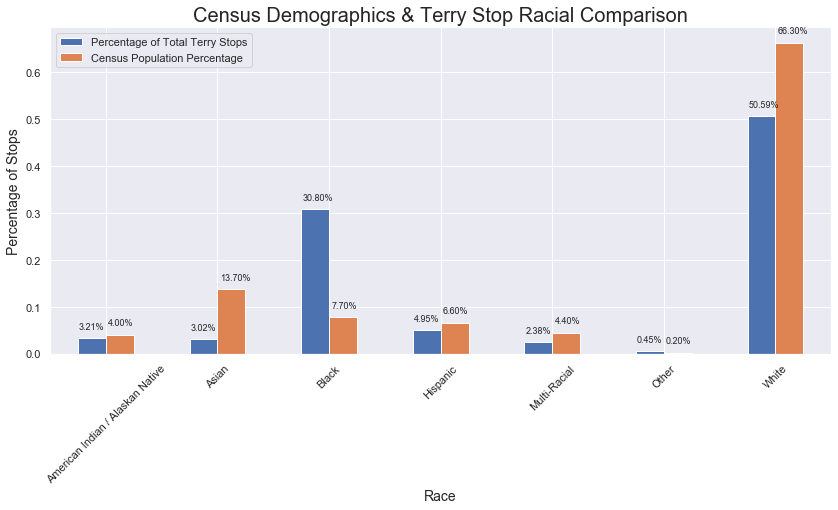

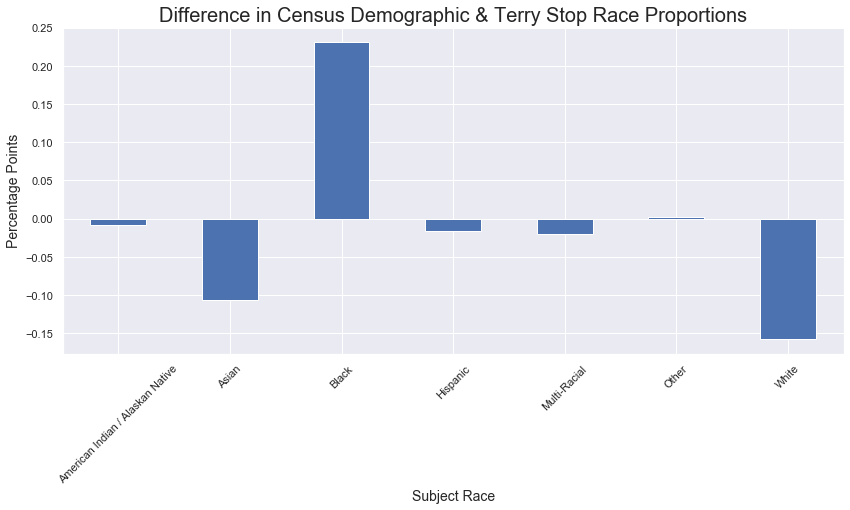

In [8]:

tmp = data[['subject_race','count']]
tmp = tmp.groupby('subject_race').count()
tmp['stop_pct'] = tmp['count'] / tmp['count'].sum()
tmp.drop(['count'], axis = 1, inplace = True)

#create dataframe with census data information & join with main information
census_data = pd.DataFrame(index = tmp.index, data = {'census_pct' : [.04,.137,.077,.066,.044,.002,np.nan,.663,]} )
tmp = tmp.join(census_data)
tmp = tmp[tmp.index != 'Unknown']


#plot the data
ax = tmp.plot(kind = 'bar', figsize = (14,6))

#display the values over the corresoponding bar graphs
for i, v in enumerate(tmp.stop_pct):
    ax.text(i-.24, v+.02, '{:.2f}%'.format(100*v),fontsize = 9 )

for i, v in enumerate(tmp.census_pct):
    ax.text(i+.02, v+.02, '{:.2f}%'.format(100*v),fontsize = 9 )
    
    


_=plt.xticks(rotation = 45)
_=plt.title('Census Demographics & Terry Stop Racial Comparison', fontsize = 20)
_=plt.xlabel('Race', fontsize = 14)
_=plt.ylabel('Percentage of Stops', fontsize = 14)
_=plt.legend(loc = 'best', labels = ['Percentage of Total Terry Stops', 'Census Population Percentage'] )
plt.show()



tmp['diff'] = tmp.stop_pct - tmp.census_pct
tmp['diff'].plot(kind = 'bar', figsize = (14,6))
_=plt.xlabel('Subject Race', fontsize = 14)
_=plt.ylabel('Percentage Points', fontsize = 14)
_=plt.title('Difference in Census Demographic & Terry Stop Race Proportions', fontsize = 20)
_=plt.xticks(rotation = 45)
plt.show()


We see that between 2015 - 2019 Black people account for 31% of total Terry Stops.  When compared to the the 2010 census population data, all groups with the exception of 'Other' and Blacks are stopped at lesser percentage point than the population. Blacks are stopped 300 times more than what the 2010 census population stated.

**Conclusion**  
There appears to be a larger proportion of black residents stopped compared to the census population proportions. Conversly there is a smaller proportion of white and asian residents stopped compared to the censur population proportions.

There appears to be a significantly larger percentage of Terry Stops of Black residents over the population make up of the area compared to other races.

### Is there an age difference in stops among the difference races?

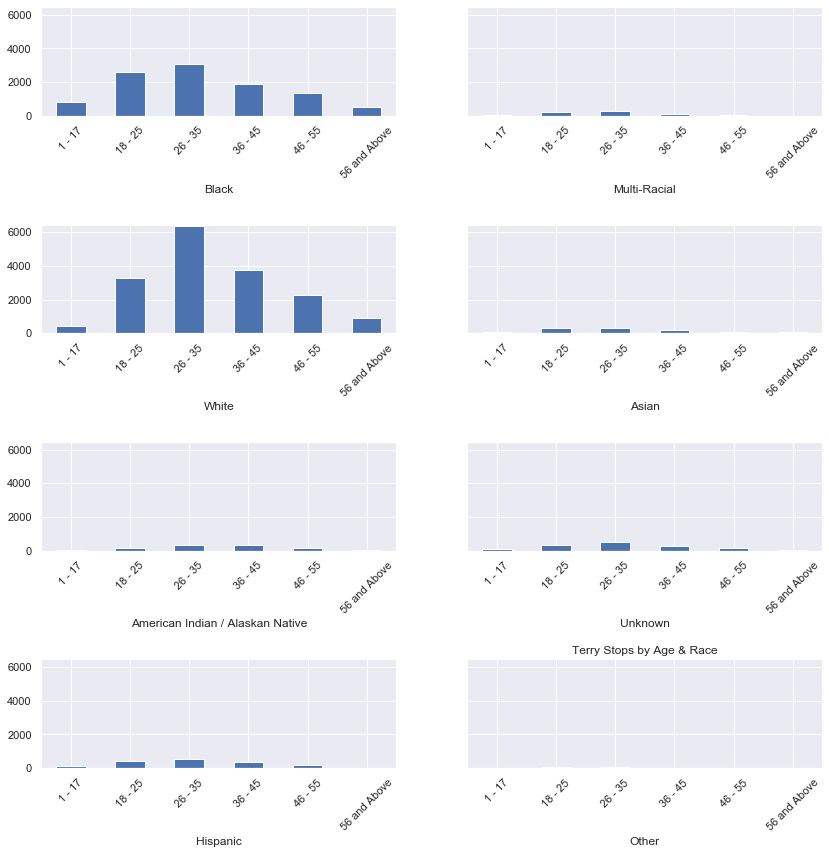

In [9]:
#generate iterables race & subplot values
races = data.subject_race.unique()
subplots = np.arange(421,429)

#generate a subset of the data
tmp = data.groupby(['subject_race','subject_age'])['count'].count()
#determine the top value of each graph
ylim = data.groupby(['subject_race','subject_age'])['count'].count().max() + 100

#build figure
f= plt.figure(figsize = (14, 14))
f.subplots_adjust(hspace = 1) #adjust the spacing between subplots to eliminate overlap


for race, p in zip(races, subplots):
        plt.subplot(p)
        axes = plt.gca()
        axes.set_ylim([0,ylim]) # set y limit equal in each graph for consistent visualizaiton
        tmp[race].plot(kind = 'bar', sharey = 'row')
        plt.xlabel(race) 
        plt.xticks(rotation = 45)
        
_=plt.title('Terry Stops by Age & Race')

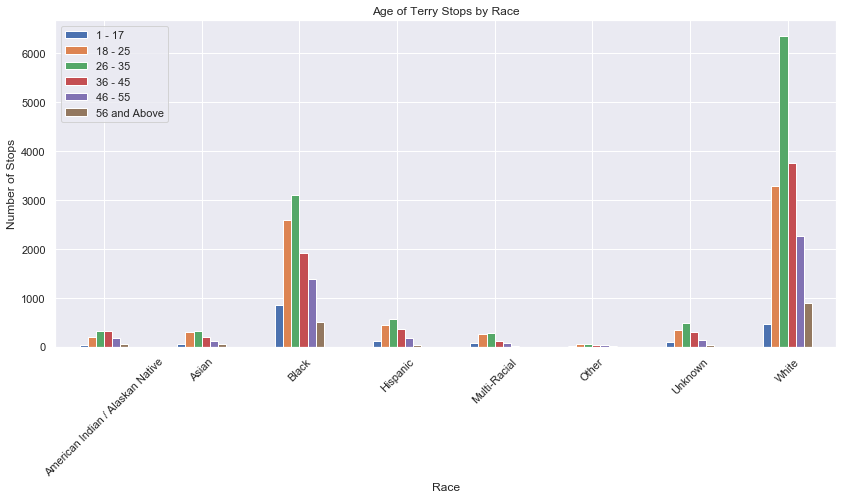

In [10]:
#subset the data 
tmp = data[['subject_race','subject_age','count']]
tmp = tmp.groupby(['subject_race','subject_age']).count().unstack(level = 'subject_age')

#generate labels for the xaxis
labels = list(tmp.columns.get_level_values(1))

tmp.plot(kind = 'bar', figsize = (14,6)) #plot the graph

_=plt.title('Age of Terry Stops by Race')
_=plt.xlabel('Race')
_=plt.xticks(rotation = 45)
_=plt.ylabel('Number of Stops')
_=plt.legend(loc = 'best', labels = labels )


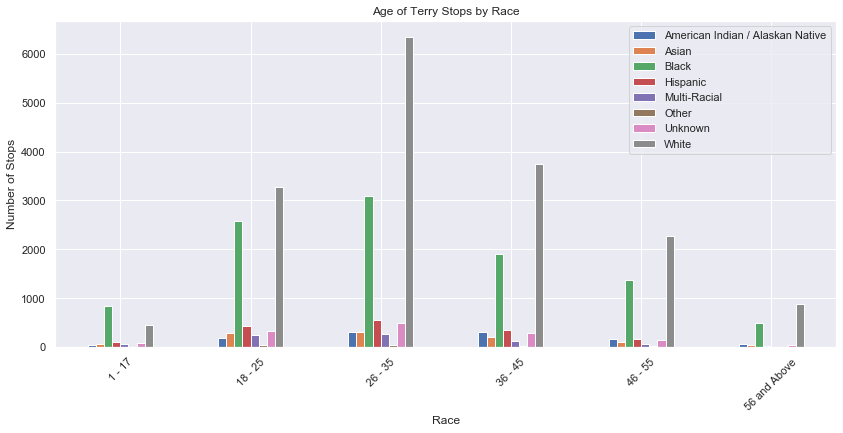

In [11]:
#subset the data
tmp = data[['subject_race','subject_age','count']]
tmp = tmp.groupby(['subject_race','subject_age']).count().unstack(level = 'subject_race')

labels = list(tmp.columns.get_level_values(1)) #generate xaxis labels

#plot the data
tmp.plot(kind = 'bar', figsize = (14,6))
_=plt.title('Age of Terry Stops by Race')
_=plt.xlabel('Race')
_=plt.xticks(rotation = 45)
_=plt.ylabel('Number of Stops')
_=plt.legend(loc = 'best', labels = labels )


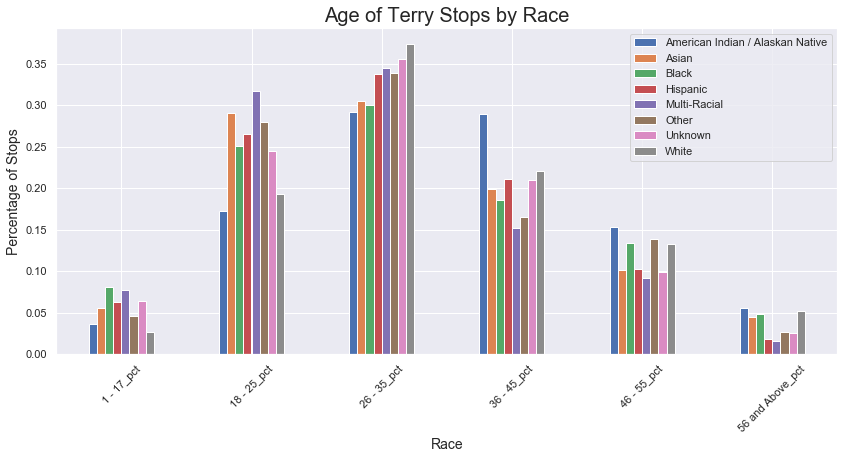

In [12]:

def age_pct(row, col):
    '''Function to convert the age column to a percentage'''
    ttl = row.sum()
    return row[col] / ttl

#subset the data
tmp = data[['subject_race','subject_age','count']]
#pivot the grouby table to generate the desired shape of the data
tmp = tmp.groupby(['subject_race','subject_age']).count().pivot_table(index = 'subject_race', 
                                                                      columns = 'subject_age', 
                                                                  values = 'count')
cols = list(tmp.columns) # list of columns for an iterable
tmp.columns = cols #remove the column categories from the dataframe

#loop through the columns and apply the function to convert to a percentage
for col in cols:
    coln = col + '_pct'
    tmp[coln] = tmp.apply(age_pct, col = col, axis = 1 )

tmp.drop(cols, axis = 1, inplace = True)   # drop the original columns
tmp = tmp.T                                #transpose the datafram
labels = list(tmp.columns)                 #obtain the labels for the plot

#generate the plot
tmp.plot(kind = 'bar', figsize = (14,6))
_=plt.title('Age of Terry Stops by Race', fontsize = 20)
_=plt.xlabel('Race', fontsize = 14)
_=plt.xticks(rotation = 45)
_=plt.ylabel('Percentage of Stops', fontsize = 14)
_=plt.legend(loc = 'best', labels = labels )

The majority of subjects stopped were aged 26-35 for all races. There is some variability in other age categories. Blacks & Multi-Racial subjects had the highest percentage of the juvenille population stopped at 8% & 7.7% respectivley, while White subjects had the least at 2.7%. Native Americans aged 36 and over have the highest percentage of stops.

### Is there a gender difference among races?

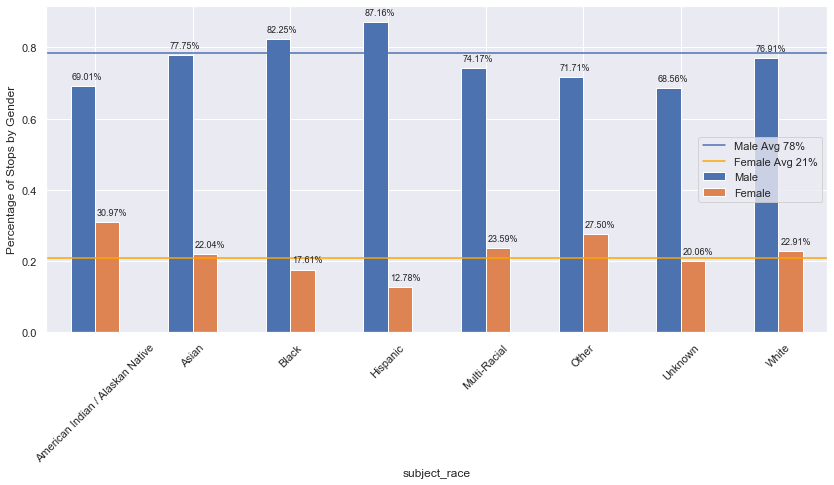

In [13]:
#subset the data & transform with pivot
tmp = data[['subject_gender', 'subject_race','count']]
tmp = tmp.groupby(['subject_race','subject_gender']).count()
tmp = tmp.pivot_table(index = 'subject_race', columns = 'subject_gender', values = 'count')

#add a new categories for additional columns
tmp.columns = tmp.columns.add_categories(['pct_male'])
tmp.columns = tmp.columns.add_categories(['pct_female'])

#add new columns with the percentage of male & female
tmp['pct_male'] = tmp.Male / tmp.sum(axis =1)
tmp['pct_female'] = tmp.Female / tmp.sum(axis =1)

male_avg = tmp.Male.sum(axis = 0) / (tmp.Male.sum(axis = 0) + 
                                     tmp.Female.sum(axis = 0) + 
                                     tmp['Unable to Determine'].sum(axis = 0))

female_avg = tmp.Female.sum(axis = 0) / (tmp.Male.sum(axis = 0) + 
                                     tmp.Female.sum(axis = 0) + 
                                     tmp['Unable to Determine'].sum(axis = 0))

tmp.drop(['Female', 'Male', 'Unable to Determine'], axis = 1, inplace = True) #drop original gender data


#plot the data
ax = tmp.plot(kind = 'bar',figsize = (14,6) )

#generate & plot the text value over each bar in the graph
for i, v in enumerate(tmp.pct_male):
    ax.text(i-.24, v+.02, '{:.2f}%'.format(100*v),fontsize = 9 )

for i, v in enumerate(tmp.pct_female):
    ax.text(i+.02, v+.02, '{:.2f}%'.format(100*v),fontsize = 9 )

_=plt.xticks(rotation = 45)
_=plt.axhline(male_avg)
_=plt.axhline(female_avg, color = 'orange', )

#_=plt.title('Terry Stops by Gender')
#_=plt.xlabel('Race')
_=plt.ylabel('Percentage of Stops by Gender')
_=plt.legend(loc = 'best', labels = ['Male Avg 78%','Female Avg 21%','Male', 'Female'] )


Across all races, police stopped mostly male subjects. This is less pronounced for hispanic subjects.

### What is the race make-up of the officers who performed stops?

,officer_race_pct,seattle_police
officer_race,,
American Indian/Alaska Native,0.008223,NaN
Asian,0.040117,0.086
Black or African American,0.039442,0.086
Hispanic or Latino,0.051601,0.052
Nat Hawaiian/Oth Pac Islander,0.010455,NaN
Not Specified,0.024611,NaN
Two or More Races,0.046490,NaN
White,0.779060,0.753


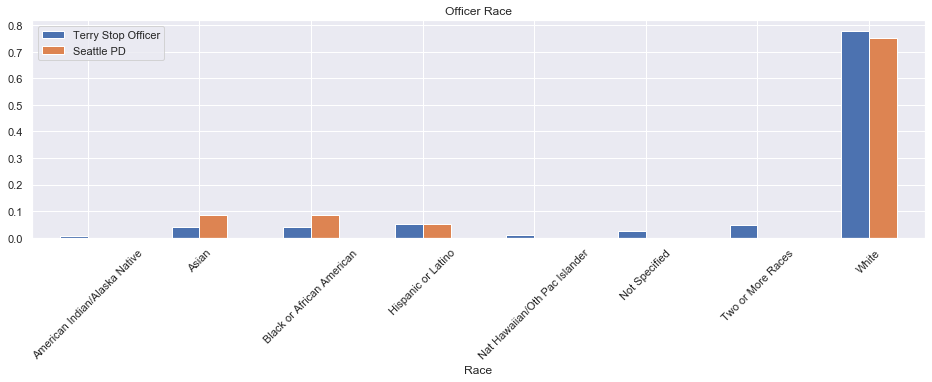

In [14]:

#subset the data
tmp = data[['officer_race','count']]
tmp = tmp.groupby('officer_race')[['count']].count()

#create dataframe with demographics of the Seattle Police Force
#https://www.governing.com/gov-data/safety-justice/police-department-officer-demographics-minority-representation.html
police_race = pd.DataFrame(index = ['White', 'Hispanic or Latino',
                                    'Black or African American', 'Asian'],
                           data = {'seattle_police' : [.753,.052,.086,.086]} )

#generate officer race percentage
tmp['officer_race_pct'] = tmp['count'] / int(tmp.sum())

tmp.drop(['count'], inplace = True, axis = 1) # drop original columns

tmp = tmp.join(police_race)                   #join both dataframes together

#create plot
tmp.plot(kind = 'bar', figsize = (16, 4))
_=plt.xticks(rotation = 45)
_=plt.title('Officer Race')
_=plt.xlabel('Race')
_=plt.legend(loc = 'best', labels = ['Terry Stop Officer', 'Seattle PD'] )
tmp

The majority of stops were from white officers. This can be explaied by the majority white police force.

A more detailed analysis of racial make up of subjects by officer's race is needed.

### What is the age make up of the officers?

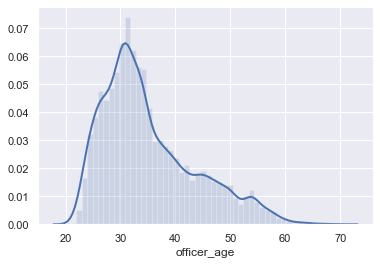

In [15]:

sns.distplot(data['officer_age'], kde_kws={'lw':2}, hist_kws={'alpha':.2} )
#_=plt.xlabel('Officer Age')


### What is the arrest & frisk rates by race?

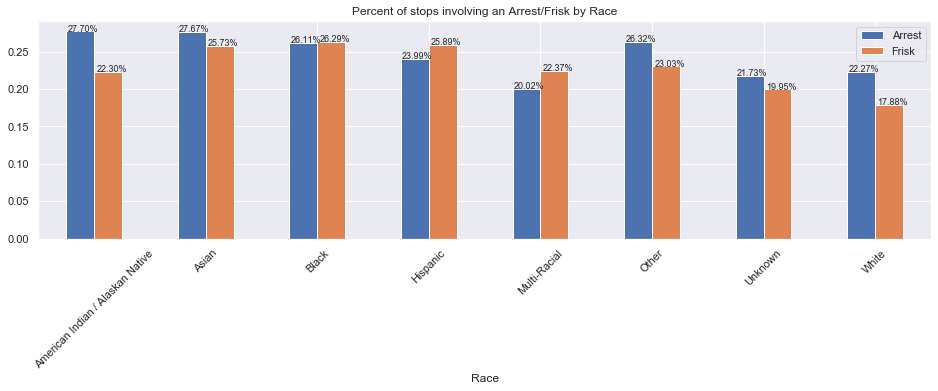

In [16]:
#subset the data
tmp = data[['subject_race', 'arrest', 'frisk','count']]
tmp = tmp.groupby('subject_race')['arrest','frisk','count'].sum()

#generate two new columns of percentages of frisks & arrests
tmp['pct_arrest'] = tmp.apply(lambda x : x['arrest'] / x['count'], axis = 1 )
tmp['pct_frisk']  = tmp.apply(lambda x : x['frisk'] / x['count'], axis = 1 )

tmp.drop(['arrest', 'frisk', 'count'], axis = 1, inplace = True)   # drop the original columns

#plot the data
ax = tmp.plot(kind = 'bar', figsize = (16, 4))

#generate text values above the columns
for i, v in enumerate(tmp.pct_arrest):
    ax.text(i-.24, v, '{:.2f}%'.format(100*v),fontsize = 9 )

for i, v in enumerate(tmp.pct_frisk):
    ax.text(i+.02, v, '{:.2f}%'.format(100*v),fontsize = 9 )

_=plt.xticks(rotation = 45)
_=plt.title('Percent of stops involving an Arrest/Frisk by Race')
_=plt.xlabel('Race')
_=plt.legend(loc = 'best', labels = ['Arrest', 'Frisk'] )

### Is there a difference in racial comparison of stops by race of the officer?

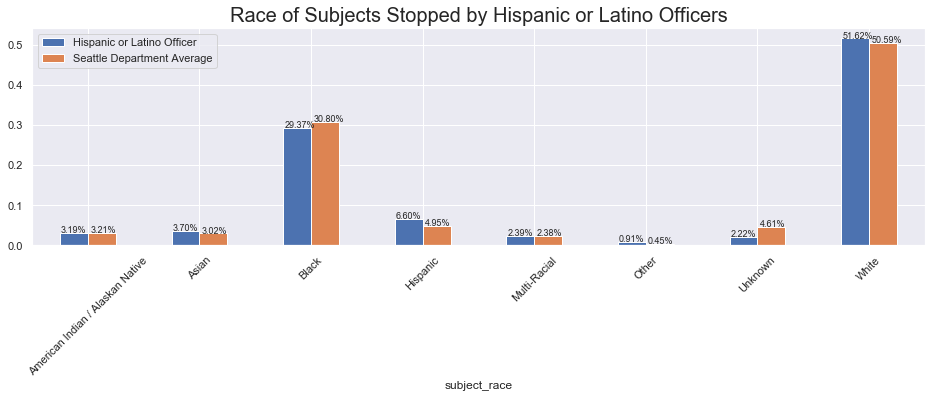

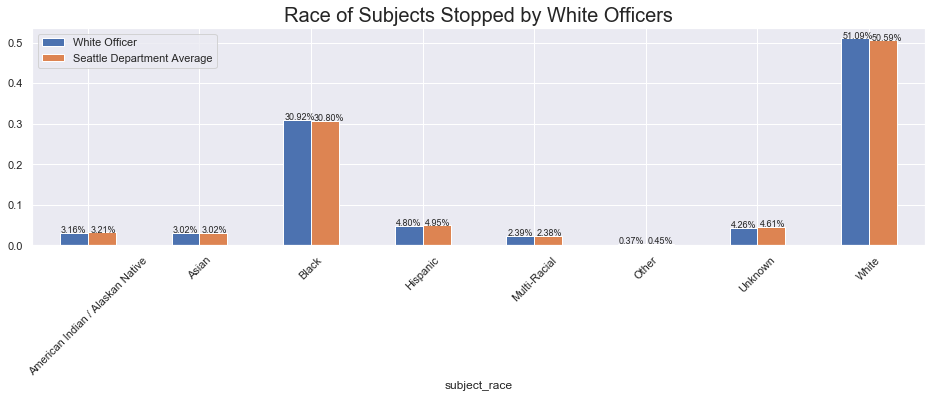

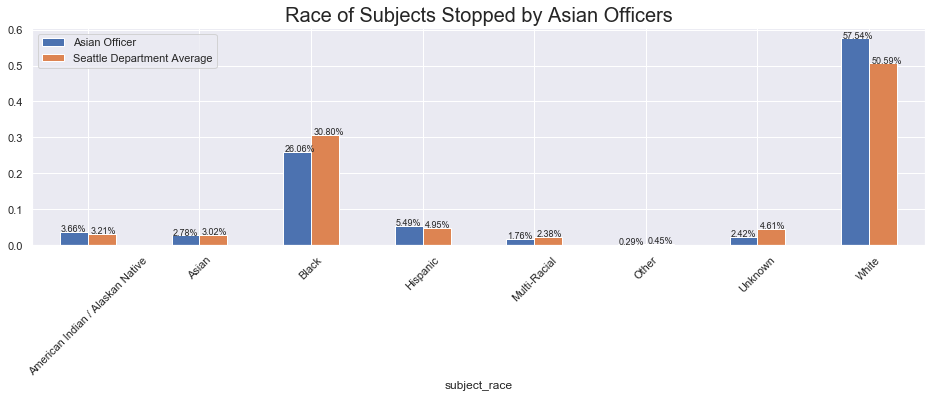

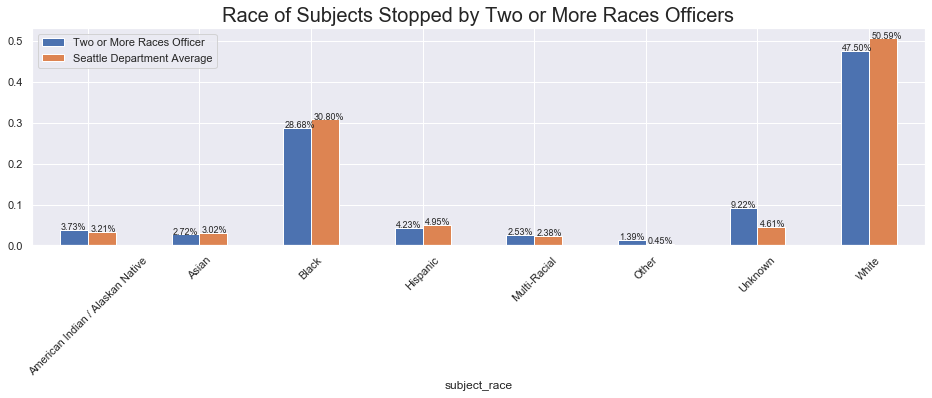

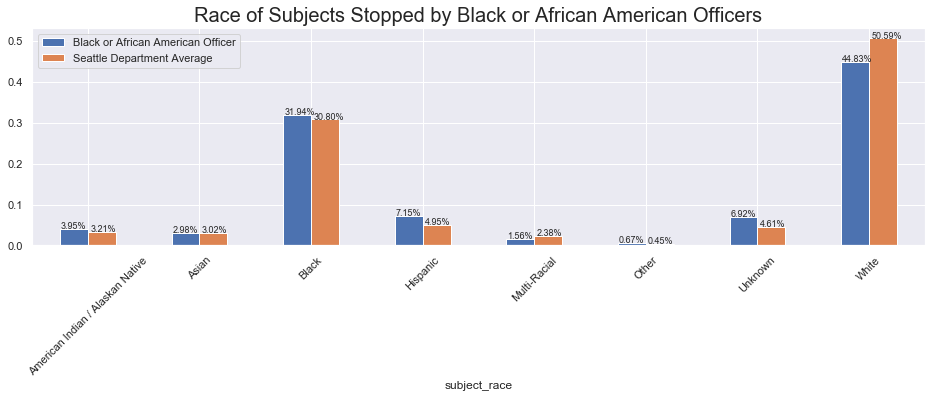

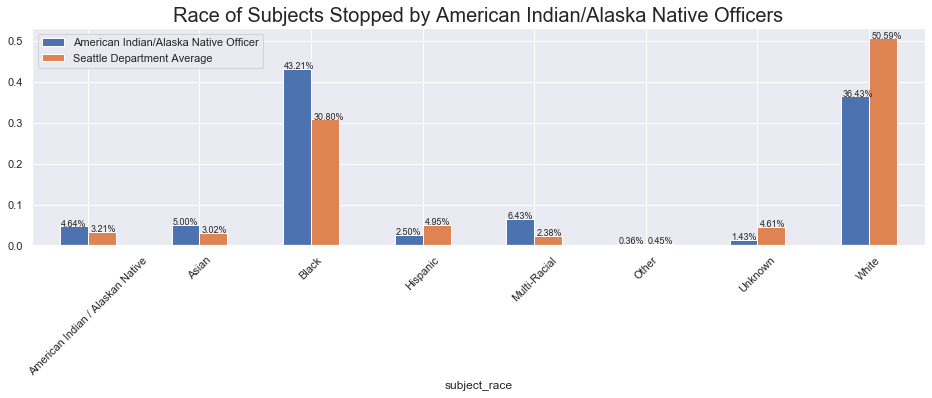

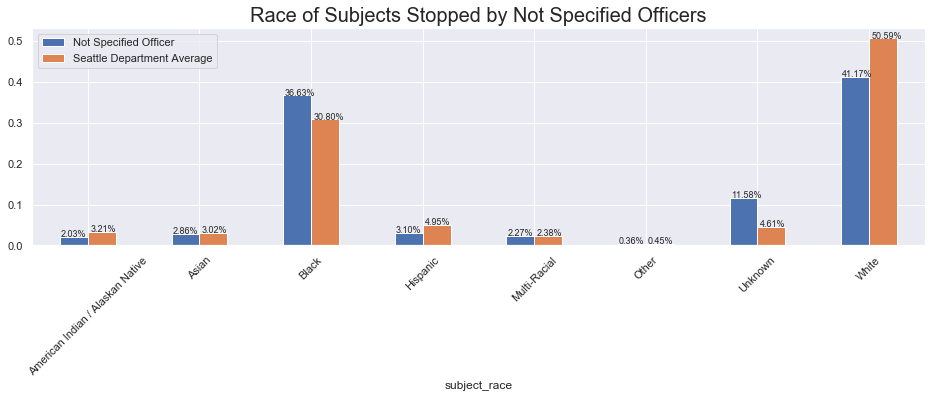

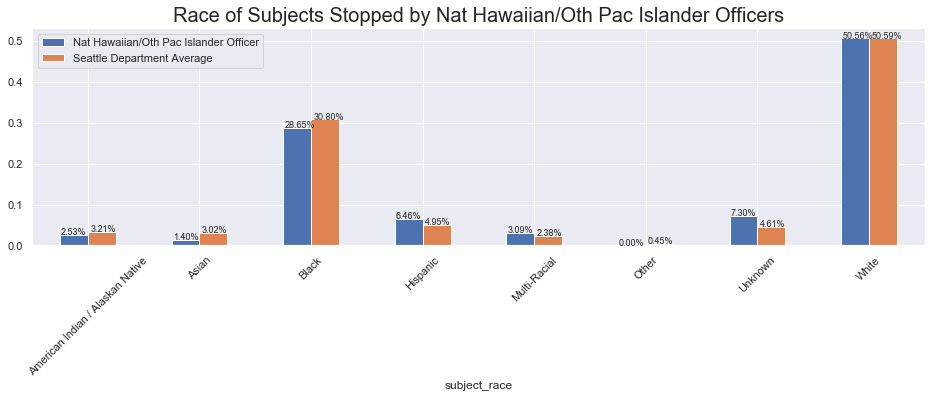

In [17]:
#subset the data
dataframe = data[['officer_race','subject_race','count']]

officer_races = list(data.officer_race.unique()) #obtain a list of all the officer races

df_list = dict() # empty dictionary to hold each filtered dataframe

#create dataframes for each race
for race in officer_races:
    df = dataframe[dataframe.officer_race == race]
    df = df.groupby('subject_race').count()
    df['stop_pct'] = df['count'] / df['count'].sum()
    df.drop(['count', 'officer_race'], axis = 1, inplace = True)
    df_list[race] = df

#create seperate dataframe for department average numbers
tmp = data[['subject_race','count']]
tmp = tmp.groupby('subject_race').count()
tmp['stop_pct'] = tmp['count'] / tmp['count'].sum()
tmp.drop(['count'], axis = 1, inplace = True)
  
    
    
#display the plots
for ttl, df in df_list.items():
    ax = pd.merge(df, tmp, left_index = True, right_index = True).plot(kind = 'bar', figsize = (16,4))
    _=plt.title('Race of Subjects Stopped by {} Officers'.format(ttl), fontsize = 20)
    _=plt.legend(labels = [ttl+' Officer', 'Seattle Department Average'] )
    _=plt.xticks(rotation = 45)
    
    #generate text values above the columns
    for i, v in enumerate(df.stop_pct):
        ax.text(i-.24, v, '{:.2f}%'.format(100*v),fontsize = 9 )
    
    for i, v in enumerate(tmp.stop_pct):
        ax.text(i+.02, v, '{:.2f}%'.format(100*v),fontsize = 9 )



Looking at the resulting graphs, each race largely follow the average of percentage of stops for each race. Asian officers stop White subjects 7% more and Native American officers stop Black subjects 13% more and White subjects 14% less. 

White officers will not show much difference from the mean due making up 78% of the officers making Terry Stops. The below chart displays the same chart of White officer stops vs. Non-White Officers

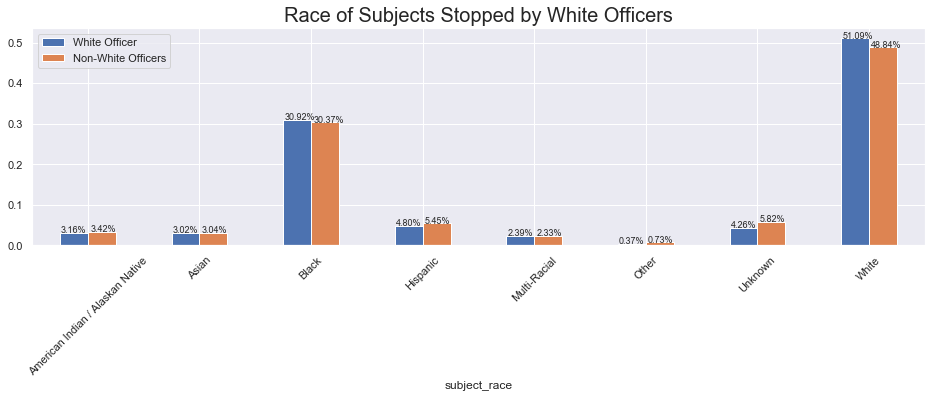

In [18]:
#subset the data
dataframe = data[['officer_race','subject_race','count']]


df = dataframe[dataframe.officer_race == 'White']
df = df.groupby('subject_race').count()
df['stop_pct'] = df['count'] / df['count'].sum()
df.drop(['count', 'officer_race'], axis = 1, inplace = True)


#create seperate dataframe for department average numbers
tmp = data[['officer_race','subject_race','count']]
tmp = tmp[tmp['officer_race']!='White']
tmp = tmp.groupby('subject_race').count()
tmp['stop_pct'] = tmp['count'] / tmp['count'].sum()
tmp.drop(['count', 'officer_race'], axis = 1, inplace = True)
  
    
    
#display the plots
ax = pd.merge(df, tmp, left_index = True, right_index = True).plot(kind = 'bar', figsize = (16,4))
_=plt.title('Race of Subjects Stopped by {} Officers'.format('White'), fontsize = 20)
_=plt.legend(labels = ['White Officer', 'Non-White Officers'] )
_=plt.xticks(rotation = 45)
    
    #generate text values above the columns
for i, v in enumerate(df.stop_pct):
    ax.text(i-.24, v, '{:.2f}%'.format(100*v),fontsize = 9 )
    
for i, v in enumerate(tmp.stop_pct):
    ax.text(i+.02, v, '{:.2f}%'.format(100*v),fontsize = 9 )